================================================================================
### Exploratory Data Analysis (EDA) - ImageArg Dataset (Gun Control)
================================================================================

This notebook explores the textual component of the ImageArg dataset focusing on the "gun control" topic. The goal is to understand dataset structure, label distribution, and key textual characteristics (tweets).

In [42]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
sns.set_theme(palette="pastel")

#Base path
path = "C:/Users/diego/Desktop/multimodal-argmining"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [10]:
#Load Dataset - each split
train_df = pd.read_csv(f"{path}/data/gun_control_train.csv")
train_df['split'] = 'train'

dev_df = pd.read_csv(f"{path}/data/gun_control_dev.csv")
dev_df['split'] = 'dev'

test_df = pd.read_csv(f"{path}/data/gun_control_test.csv")
test_df['split'] = 'test'

df = pd.concat([train_df, dev_df, test_df], ignore_index=True) 
df.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split
0,1372936384034447366,https://t.co/FpkVZ8ESy0,More Asian-Americans Are Buying Guns For Prote...,oppose,no,train
1,1327310308260667393,https://t.co/KrJTpJR3Ke,"""I will protect your Bill of Rights. Gun contr...",oppose,no,train
2,1334523148692312065,https://t.co/hBAV1pPCY9,#guns #2A 6-Time Olympic Shooting Medalist Say...,oppose,no,train
3,1324087921641721856,https://t.co/LfIzR6iPA3,Congratulations @ForHD65 on your victory! \n\n...,support,no,train
4,1313162243035607040,https://t.co/MZyeIP6Mtx,Dr. Cindy Banyai supports common sense gun saf...,support,no,train


### Columns Description

- **tweet_id**: Unique identifier of the tweet (string or integer).
- **tweet_url**: Original link to the tweet (not always needed for analysis).
- **tweet_text**: The text content of the tweet (our main focus for EDA).
- **stance**: Annotated argumentative stance towards gun control (support, oppose)
- **persuasiveness**: Whether the image (attached to the tweet) contributes to the persuasiveness of the argument (yes/no).
- **split**: Dataset split for experiments(train, val, test).

In [12]:
#Dataset shape
print("Dataset shape:", df.shape)

#Shape per splits
print(df['split'].value_counts())

#Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Dataset shape: (1173, 6)
split
train    923
test     150
dev      100
Name: count, dtype: int64

Missing values per column:
tweet_id          0
tweet_url         0
tweet_text        0
stance            0
persuasiveness    0
split             0
dtype: int64


In [14]:
#Since we only want to analyze the train data for future preprocessing techniques or feature engineering 
#we will filter it

train_df = df[df['split'] == 'train'].copy()

Stance value counts:
 stance
support    475
oppose     448
Name: count, dtype: int64


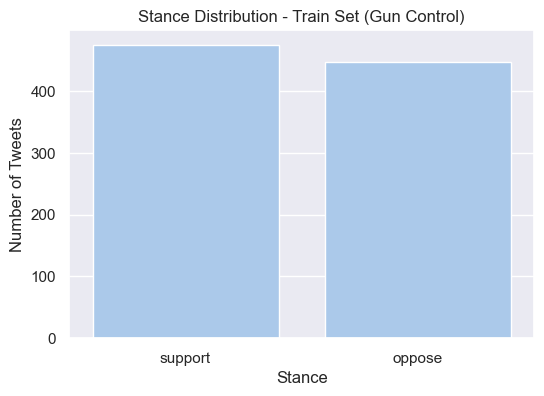


Persuasiveness value counts:
 persuasiveness
no     672
yes    251
Name: count, dtype: int64


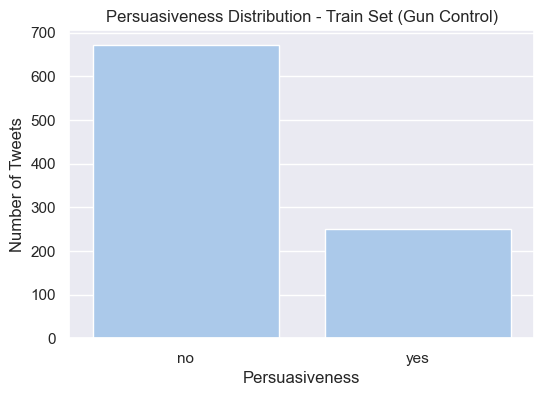

In [15]:
#Stance distribution
stance_counts = train_df['stance'].value_counts()
print("Stance value counts:\n", stance_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=stance_counts.index, y=stance_counts.values)
plt.title("Stance Distribution - Train Set (Gun Control)")
plt.ylabel("Number of Tweets")
plt.xlabel("Stance")
plt.show()

#Persuasiveness distribution
persuasion_counts = train_df['persuasiveness'].value_counts()
print("\nPersuasiveness value counts:\n", persuasion_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=persuasion_counts.index, y=persuasion_counts.values)
plt.title("Persuasiveness Distribution - Train Set (Gun Control)")
plt.ylabel("Number of Tweets")
plt.xlabel("Persuasiveness")
plt.show()


**Stance:** The dataset is relatively balanced, with 475 tweets supporting gun control and 448 opposing it.
**Persuasiveness:** Most images do not contribute to persuasiveness, with 672 labeled no versus 251 labeled yes.

Character count statistics:
count    923.000000
mean     245.206934
std       65.734788
min       52.000000
25%      205.000000
50%      269.000000
75%      299.000000
max      335.000000
Name: char_count, dtype: float64

Word count statistics:
count    923.000000
mean      35.513543
std       11.413761
min        6.000000
25%       28.000000
50%       38.000000
75%       44.000000
max       58.000000
Name: word_count, dtype: float64


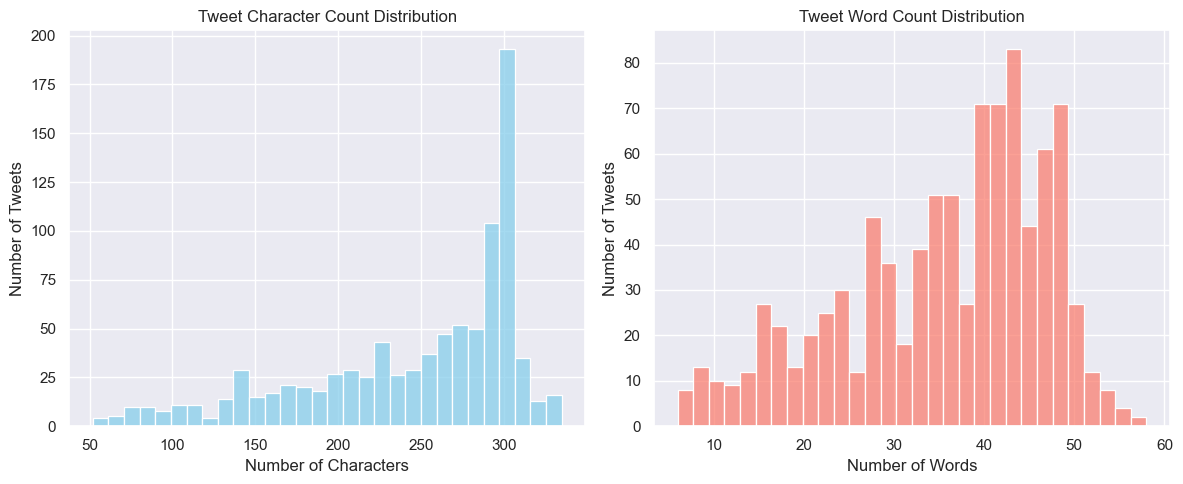

In [17]:
#Tweet Length 

#Add auxiliar lenght columns 
train_df['char_count'] = train_df['tweet_text'].apply(len)
train_df['word_count'] = train_df['tweet_text'].apply(lambda x: len(str(x).split()))


print("Character count statistics:")
print(train_df['char_count'].describe())
print("\nWord count statistics:")
print(train_df['word_count'].describe())

#Histograms
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(train_df['char_count'], bins=30, color='skyblue')
plt.title("Tweet Character Count Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Tweets")

plt.subplot(1,2,2)
sns.histplot(train_df['word_count'], bins=30, color='salmon')
plt.title("Tweet Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Tweets")

plt.tight_layout()
plt.show()


**Characters:** Tweets are moderately long, averaging ~245 characters, with most between 205 and 299 characters. Minimum length is 52, maximum 335.

**Words:** Tweets contain on average ~36 words, with the majority ranging from 28 to 44 words. Minimum is 6 words, maximum 58.

C:\Users\diego\AppData\Local\Temp\ipykernel_30732\1820048907.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="pastel")


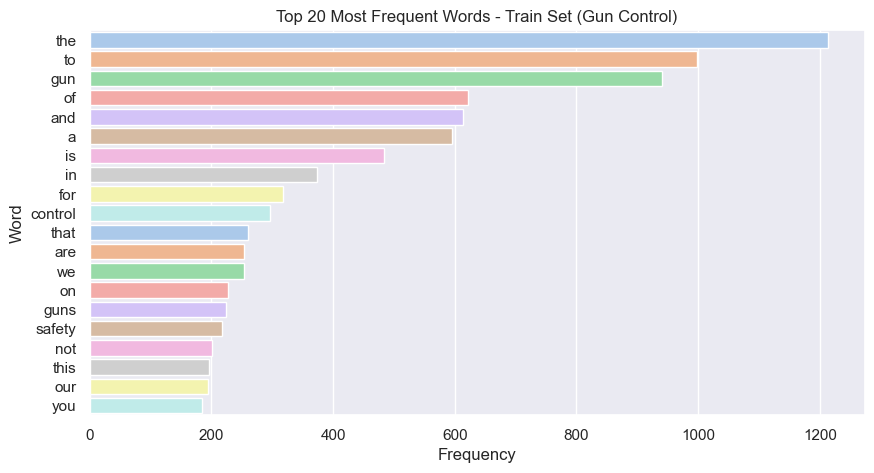

In [ ]:

#Tokenize and count words
all_words = " ".join(train_df['clean_text']).split()
word_freq = Counter(all_words)

#Top 20 most common words
most_common_words = word_freq.most_common(20)

words, counts = zip(*most_common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette="pastel")
plt.title("Top 20 Most Frequent Words - Train Set (Gun Control)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()


C:\Users\diego\AppData\Local\Temp\ipykernel_30732\1141770505.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts_nostop), y=list(words_nostop), palette="muted")


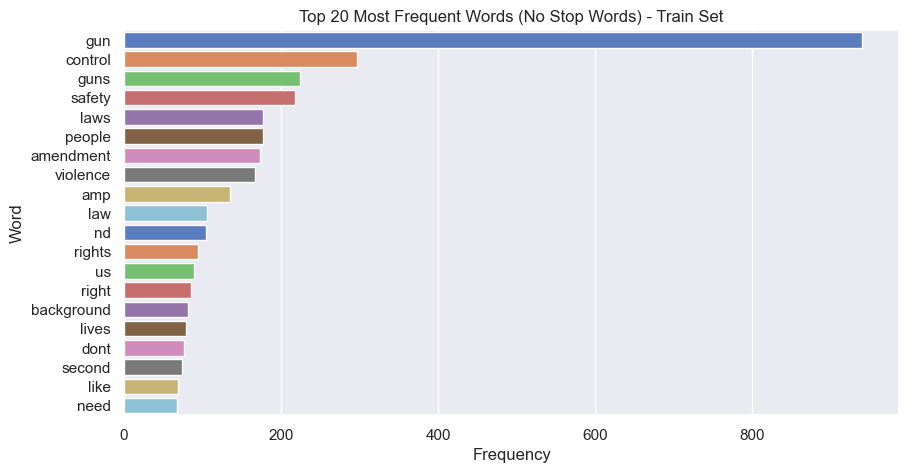

In [26]:
#Most Frequent Words - Train Set

#Text Cleaning simple function 
def clean_text(text):
    text = str(text).lower()    
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  
    text = re.sub(r"@\w+", "", text)            
    text = re.sub(r"#\w+", "", text)            
    text = re.sub(r"[^a-z\s]", "", text)       
    return text

#Clean Texts
train_df['clean_text'] = train_df['tweet_text'].apply(clean_text)


#Remove stopwords function
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

#Remove stopwrods
train_df['clean_text_nostop'] = train_df['clean_text'].apply(remove_stopwords)


all_words_nostop = " ".join(train_df['clean_text_nostop']).split()
word_freq_nostop = Counter(all_words_nostop)

# Top 20 most common words without stop words
most_common_words_nostop = word_freq_nostop.most_common(20)

#Plot top 20 words
words_nostop, counts_nostop = zip(*most_common_words_nostop)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts_nostop), y=list(words_nostop), palette="muted")
plt.title("Top 20 Most Frequent Words (No Stop Words) - Train Set")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

C:\Users\diego\AppData\Local\Temp\ipykernel_30732\2653690632.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="pastel")


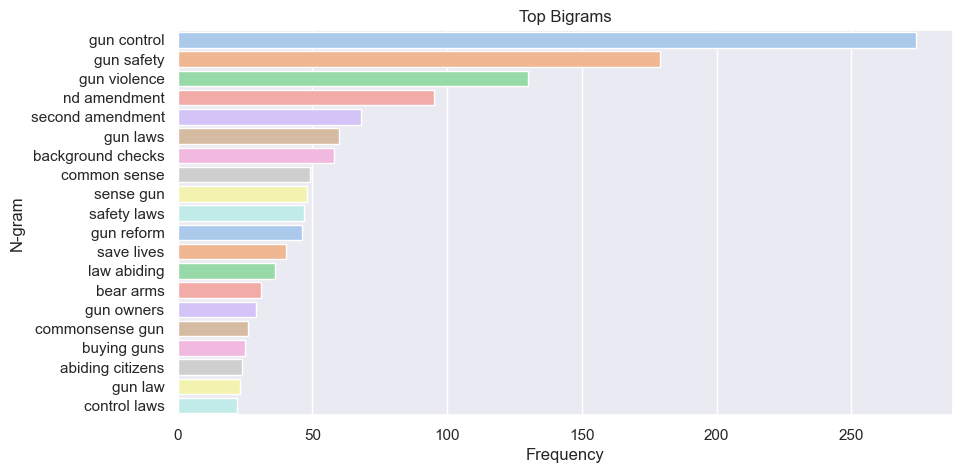

C:\Users\diego\AppData\Local\Temp\ipykernel_30732\2653690632.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="pastel")


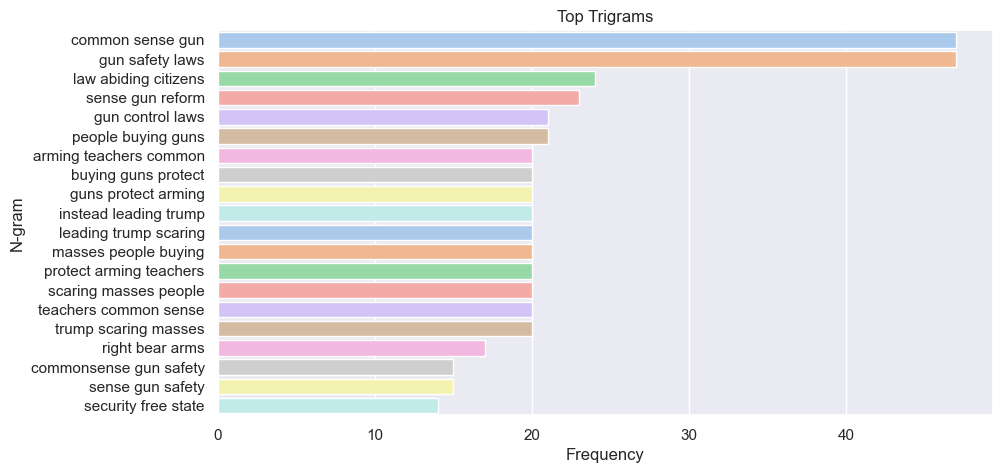

In [47]:
#Bigram and Trigram Analysis (without stop words)


#Bigram analysis
bigram_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X_bigrams = bigram_vectorizer.fit_transform(train_df['clean_text_nostop'])
bigram_counts = X_bigrams.sum(axis=0).A1
bigram_features = bigram_vectorizer.get_feature_names_out()
bigram_freq = dict(zip(bigram_features, bigram_counts))

#Trigram analysis
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), stop_words='english')
X_trigrams = trigram_vectorizer.fit_transform(train_df['clean_text_nostop'])
trigram_counts = X_trigrams.sum(axis=0).A1
trigram_features = trigram_vectorizer.get_feature_names_out()
trigram_freq = dict(zip(trigram_features, trigram_counts))


#Top 20 n-grams
top_bigrams = Counter(bigram_freq).most_common(20)
top_trigrams = Counter(trigram_freq).most_common(20)

#Plots
ngrams, counts = zip(*top_bigrams)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(ngrams), palette="pastel")
plt.title("Top Bigrams")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()

ngrams, counts = zip(*top_trigrams)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(ngrams), palette="pastel")
plt.title("Top Trigrams")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()


C:\Users\diego\AppData\Local\Temp\ipykernel_30732\2740864600.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts1), y=list(ngrams1), palette="Blues_r")


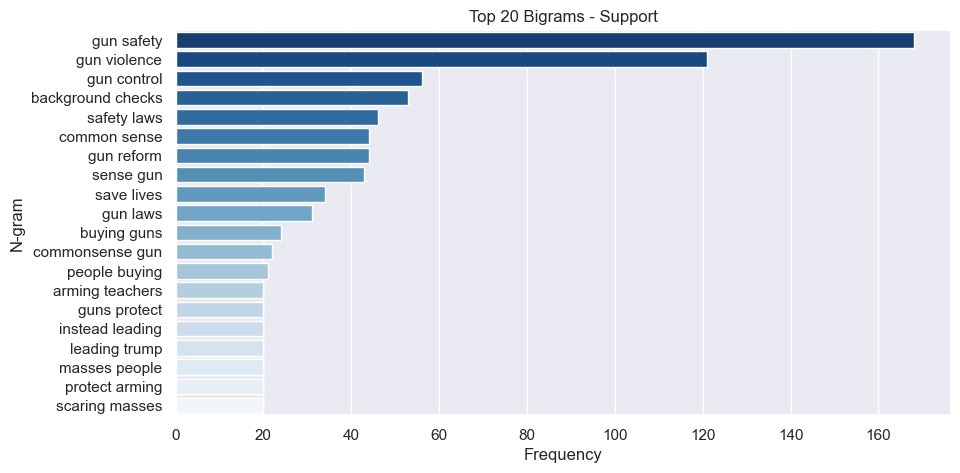

C:\Users\diego\AppData\Local\Temp\ipykernel_30732\2740864600.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts1), y=list(ngrams1), palette="Reds_r")


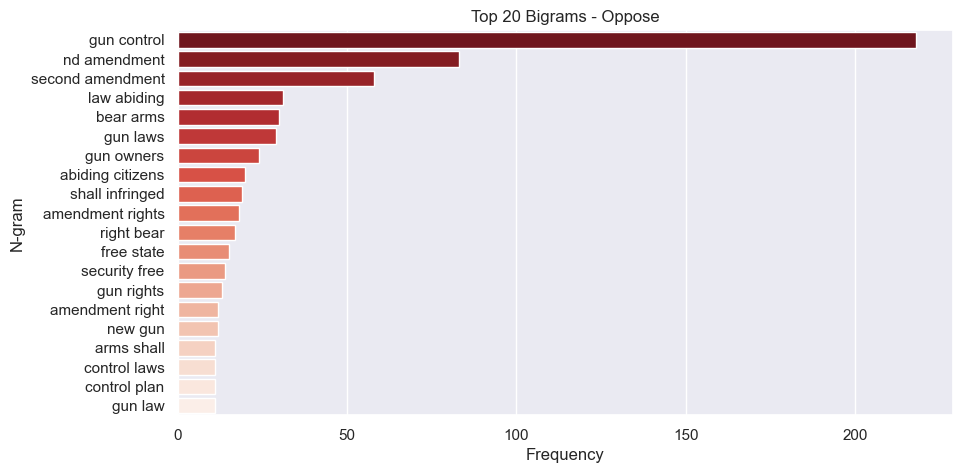

In [ ]:
# N-gram Comparison by Stance - Train Set (without stop words)

#Split by stance
support_texts = train_df[train_df['stance']=='support']['clean_text_nostop']
oppose_texts = train_df[train_df['stance']=='oppose']['clean_text_nostop']

# Function to compute n-gram frequencies
def get_ngram_freq(text_series, ngram=2,stop_words='english'):
    vectorizer = CountVectorizer(ngram_range=(ngram,ngram), stop_words=stop_words)
    X = vectorizer.fit_transform(text_series)
    counts = X.sum(axis=0).A1
    features = vectorizer.get_feature_names_out()
    return dict(zip(features, counts))

#Compute bigram frequencies
support_bigrams = get_ngram_freq(support_texts, ngram=2)
oppose_bigrams = get_ngram_freq(oppose_texts, ngram=2)


#Plots
#Support
support = Counter(support_bigrams).most_common(20)
ngrams1, counts1 = zip(*support)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts1), y=list(ngrams1), palette="Blues_r")
plt.title(f"Top 20 Bigrams - Support")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()

#Oppose
oppose = Counter(oppose_bigrams).most_common(20)
ngrams1, counts1 = zip(*oppose)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts1), y=list(ngrams1), palette="Reds_r")
plt.title(f"Top 20 Bigrams - Oppose")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()